### DNN을 이용한 MNIST 필기체 숫자 인식


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

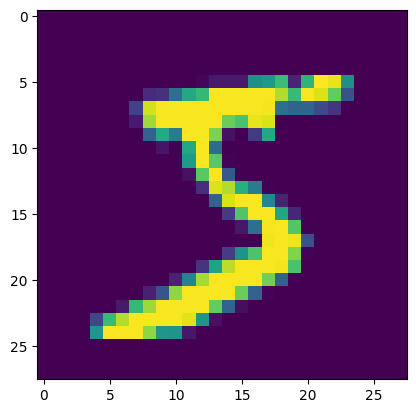

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.imshow(x_train[0])

x_train, x_test = x_train / 255.0, x_test / \
    255.0  # 픽셀값을 0.0과 1.0 사이의 값으로 변환(정규화)

In [3]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [4]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# (비교) p.269 MLP에서는 아래처럼 구성. 정확도(accuracy)는 96.x% 정도로 약간 못하다.
# model.compile(optimizer='rmsprop',
#                 loss='mse',
#                 metrics=['accuracy'])

model.fit(x_train, y_train, epochs=30, workers=8, use_multiprocessing=True)
model.evaluate(x_test, y_test)

Epoch 1/30


1875/1875 [==============================] - 4s 2ms/step - loss: 0.2183 - accuracy: 0.9354
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0970 - accuracy: 0.9702
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0679 - accuracy: 0.9788
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0531 - accuracy: 0.9835
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0431 - accuracy: 0.9859
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0354 - accuracy: 0.9885
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0319 - accuracy: 0.9891
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0273 - accuracy: 0.9908
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0242 - accuracy: 0.9920
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0

[0.11929294466972351, 0.9830999970436096]

In [5]:
# 모델 저장하기
from keras.models import load_model
import numpy as np

model.summary()
model.save("mymodel")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: mymodel\assets


INFO:tensorflow:Assets written to: mymodel\assets


# Simple Example of Ensemble.


## Load the required modules..

### In this example using Voting classifier to implement ensemble


In [6]:
# Module Import
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from scikeras.wrappers import KerasClassifier

### These models are non-CNN. so flatten to input


In [7]:
# Reshape the images for non-CNN models
x_train_flat = x_train.reshape((x_train.shape[0], -1))[:1000]
x_test_flat = x_test.reshape((x_test.shape[0], -1))[:1000]

In [8]:
# Check the Shape
x_train_flat.shape

(1000, 784)

### Prepare each model for use in VotingClassifier

In [16]:
# Define individual models
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=4)
svm_model = SVC(
    kernel="rbf",
    C=1,
    probability=True,
)
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=4)
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.003, max_depth=3
)
mlp_model = MLPClassifier(hidden_layer_sizes=(512,), max_iter=30)
seq_model = KerasClassifier(seq_model)

### Create Voting Classifier with parameters

In [32]:
# Create a voting classifier
voting_classifier = VotingClassifier(
    estimators=[
        ("random_forest", rf_model),
        ("svm", svm_model),
        ("knn", knn_model),
        ("gradient_boosting", gb_model),
        ("mlp", mlp_model),
    ],
    voting="soft",  # 'soft' enables probability voting, hard majority vote
    verbose=True,
)

### and make Fit to Learning Process
---
Voting Classifier is majority classification.
Voting Classifier is divided into two types.
1. Hard Voting
Generate multiple models and compare results.
and the results of each classifier are aggregated to determine which one get the most votes
The most voted classifier is final prediction result.

2. Soft Voting
When all classifiers used in the ensemble are capable of making probability predictions
Averages Each prediction of classifiers and most probability is prediction result (Weight Vote)

In [33]:
# Fit the ensemble model
voting_classifier.fit(
    x_train_flat,
    y_train[:1000],
)

[Voting] ............ (1 of 5) Processing random_forest, total=   0.2s
[Voting] ...................... (2 of 5) Processing svm, total=   0.6s
[Voting] ...................... (3 of 5) Processing knn, total=   0.0s
[Voting] ........ (4 of 5) Processing gradient_boosting, total=  40.6s
[Voting] ...................... (5 of 5) Processing mlp, total=   1.7s


c:\Users\PINEAPPLE\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(n_jobs=4)),
                             ('svm', SVC(C=1, probability=True)),
                             ('knn', KNeighborsClassifier(n_jobs=4)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(learning_rate=0.003)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(512,),
                                            max_iter=30))],
                 verbose=True, voting='soft')

### Evaluate the classifier

In [34]:
# Predict and evaluate
y_pred_Voting = voting_classifier.predict(x_test_flat)
accuracy = accuracy_score(y_test[:1000], y_pred_Voting)
print(f"Ensemble Accuracy: {accuracy}")

Ensemble Accuracy: 0.879


### load the test image

In [35]:
import cv2

In [36]:
img = cv2.imread("4.jpg", cv2.IMREAD_GRAYSCALE)

# Normalize
img = cv2.resize(img, (28, 28))
img = img.astype("float32")
img = 255 - img
img = img / 255.0  # 픽셀값을 0.0과 1.0 사이의 값으로 변환(정규화)

# 1D Flatten
img_flat = img.reshape((1, -1))

### make fit each model to get probability result

In [37]:
# Train each model
rf_model.fit(x_train_flat, y_train[:1000])
svm_model.fit(x_train_flat, y_train[:1000])
knn_model.fit(x_train_flat, y_train[:1000])
gb_model.fit(x_train_flat, y_train[:1000])
mlp_model.fit(x_train_flat, y_train[:1000])

# Print each model prediction
rf_single_proba = rf_model.predict_proba(img_flat)
svm_single_proba = svm_model.predict_proba(img_flat)
knn_single_proba = knn_model.predict_proba(img_flat)
gb_single_proba = gb_model.predict_proba(img_flat)
mlp_single_proba = mlp_model.predict_proba(img_flat)

c:\Users\PINEAPPLE\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


### Print each results

In [41]:
# Predict and evaluate
ensemble_Voting = voting_classifier.predict(img_flat)
ensemble_Voting_proba = voting_classifier.predict_proba(img_flat)

print(f"Predict: \n{ensemble_Voting}")
print(
    f"Prediction precentage : \n{ensemble_Voting_proba[0]}, {np.argmax(ensemble_Voting_proba[0])}")

print(
    f"Random Forest 모델의 예측 확률:\n{rf_single_proba[0]}, {np.argmax(rf_single_proba[0])}")
print(
    f"SVM 모델의 예측 확률:\n{svm_single_proba[0]}, {np.argmax(svm_single_proba[0])}")
print(
    f"KNN 모델의 예측 확률:\n{knn_single_proba[0]}, {np.argmax(knn_single_proba[0])}")
print(
    f"Gradient Boosting 모델의 예측 확률:\n{gb_single_proba[0]}, {np.argmax(gb_single_proba[0])}")
print(
    f"MLP 모델의 예측 확률:\n{mlp_single_proba[0]}, {np.argmax(mlp_single_proba[0])}")

Predict: 
[4]
Prediction precentage : 
[0.02087945 0.22555779 0.07061357 0.03069072 0.2578912  0.05627304
 0.07283908 0.17475964 0.03166461 0.05883091], 4
Random Forest 모델의 예측 확률:
[0.03 0.08 0.06 0.07 0.21 0.11 0.16 0.14 0.06 0.08], 4
SVM 모델의 예측 확률:
[0.00550762 0.10542434 0.06095543 0.01847058 0.42688701 0.04528446
 0.06205485 0.20100799 0.01795279 0.05645493], 4
KNN 모델의 예측 확률:
[0.  0.8 0.  0.  0.2 0.  0.  0.  0.  0. ], 1
Gradient Boosting 모델의 예측 확률:
[0.06497336 0.07883952 0.07420977 0.06861575 0.08023411 0.07411198
 0.06294605 0.36332181 0.06078363 0.07196402], 7
MLP 모델의 예측 확률:
[0.00166775 0.06175921 0.09861113 0.01489627 0.45772438 0.02289608
 0.19047354 0.08776034 0.01422777 0.04998352], 4
